# Week 5: Fairness & Interpretability

---


### Questions from the resources


**Question 1.**
**What is the goal of "fairness" in machine learning?**

- To "prevent machine learning algorithms from perpetuating the marginalization or discrimination of persons based on income, sexual orientation, race, gender identity, or religion"


**Question 2.**
**Can machine learning perpetuate biases and/or create health disparities?**
- Yes, but primarily by way of biases embedded in the data or model/feature design

**Question 3.**
**Which of the following situations may perpetuate biases?**

- Automated algorithms to approve loan requests using demographic and income features
- An algorithm to identify melanoma's from pictures that reports poor accuracy for darker skin tones
- A diagnostic prediction algorithm for early cancer detection that only works for a single acenstral group
- Automated algorithms to approve, deny, and set bail

**Question 4.**
**Joy Buolamwini's *Inclusive Coding* discusses,**

- Who, how, and why we code matters when fighting bias in ML

**Question 5.**
**Timnit Gebru advocates for the use of,**

- Datasheets for datasets that discuss recommended usage and standards for using the dataset


# Coding Exercises

### For these exercises, we are going to be using `synthetic` data

### This data is not real and was designed to highlight `potential challenges` in datasets and analyses

In [2]:
#pip install shap

     |████████████████████████████████| 433 kB 2.3 MB/s            
     |████████████████████████████████| 2.3 MB 35.3 MB/s            
     |████████████████████████████████| 25.5 MB 5.6 MB/s            
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:

import numpy as np
import pandas as pd
import os 
from tqdm import tqdm

import shap; shap.initjs()

from sklearn.datasets import make_classification 
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

from importlib import reload
import week_5_helperFx as fx


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



## Coding Exercise: Underrepresentation

In this problem we are going to be building a penalized logisitic regression model (`L1 Penalty`) to predict Major Depressive Disorder (MDD)

**Your task**,

- Run the code to get train/test accuracy, how does the model do?
- After you run this, 
    - add code, where specified, to create a test sets that are stratified by sex,
    - uncomment associated lines to store and print accuracy stratified by sex
    
**How well does this model do by sex?**

In [20]:

# Number of males/females in our dataset
m_n, f_n = 10000, 500

# Store performance
tr_acc, te_acc, m_te_acc, f_te_acc = [], [], [], []

# Train a couple times (synthetic data performance can vary)
num_iter = 10


for ii in tqdm(range(num_iter)):
    
    # Generate synthetic data
    dat = fx.Create_MDD(m_n, f_n)
    X, y = dat.X, dat.y

    # Create splits
    kf = KFold(n_splits=5)
    
    # Train/eval for each fold
    for tr_idx, te_idx in kf.split(y):
        
        # Split train/test
        tr_x, te_x =  X.iloc[tr_idx, :], X.iloc[te_idx, :]
        tr_y, te_y =  y.iloc[tr_idx], y.iloc[te_idx]

        # Fit our model
        logl1 = LogisticRegression(penalty='l1', solver='liblinear')
        logl1.fit(tr_x, tr_y)
        
        # Get our predictions
        tr_pred = logl1.predict(tr_x)
        te_pred = logl1.predict(te_x)
        
        # Get accuracy
        tr_acc.append(accuracy_score(tr_y, tr_pred))
        te_acc.append(accuracy_score(te_y, te_pred))
        
        
        '''#################################################
        # Split test into M/F only and evaluate performance
        #################################################'''
        
        # Stratify test set by sex
        m_te_x =te_x[te_x['sex'] == 0.0]
        m_te_y =te_y[te_x['sex'] == 0.0]
        f_te_x =te_x[te_x['sex'] == 1.0]
        f_te_y =te_y[te_x['sex'] == 1.0]

        # Get our predictions
        te_pred_m = logl1.predict(m_te_x)
        te_pred_f = logl1.predict(f_te_x)

        # Get accuracy
        m_te_acc.append(accuracy_score(m_te_y, te_pred_m))
        f_te_acc.append(accuracy_score(f_te_y, te_pred_f))


print(f'Train Acc: {np.mean(np.array(tr_acc)):.3f} '
      f'Test Acc: {np.mean(np.array(te_acc)):.3f} '
      f'Test Acc Male: {np.mean(np.array(m_te_acc)):.3f} '
      f'Test Acc Female: {np.mean(np.array(f_te_acc)):.3f}')


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.21it/s]

Train Acc: 0.975 Test Acc: 0.975 Test Acc Male: 0.987 Test Acc Female: 0.714


## Visualize accuracy, by sex, as a function of composition (might take a few minutes to run)

**You don't need to code anything here, just run the cells and visualize the output for the questions**

**Here we can plot,**

    1. Total performance
    2. Male performance
    3. Female performance
    

### Questions

6. **How does our performance vary as a function of composition of M/F?**

7. **Is this something we would have caught just viewing *total* accuracy?**

8. **Might this create health disparities? How?**


100%|███████████████████████████████████████████| 28/28 [00:31<00:00,  1.12s/it]


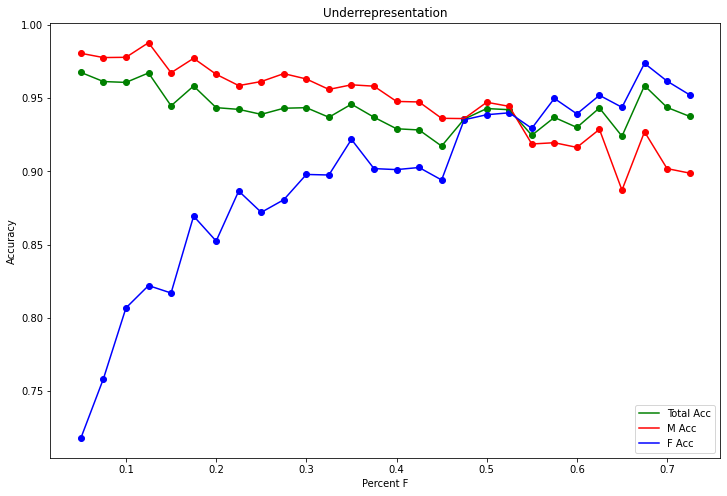

In [23]:

# Range of splits we'll try
x = np.arange(.05, .75, .025)

# Total number of subjects
n = 2000

# Create overarching arrays to store performance
perf = np.zeros(x.shape)
m_perf = np.zeros(x.shape)
f_perf = np.zeros(x.shape)

# Loop through all ranges of x
for ind, p in enumerate(tqdm(x)):
    
    # Composition of dataset
    m_n = int(n * (1 - p))
    f_n = int(n * p)

    # Store performance
    te_acc, m_te_acc, f_te_acc = [], [], []

    # Train a couple times (synthetic data performance can vary)=
    for ii in range(20):

        # Generate data
        dat = fx.Create_MDD(m_n, f_n)
        X, y = dat.X, dat.y

        # Create splits
        kf = KFold(n_splits=5)

        # Train/eval for each fold
        for tr_idx, te_idx in kf.split(y):
            
            # Split train/test
            tr_x, te_x =  X.iloc[tr_idx, :], X.iloc[te_idx, :]
            tr_y, te_y =  y.iloc[tr_idx], y.iloc[te_idx]

            # Fit our model
            logl1 = LogisticRegression(penalty='l1', solver='liblinear')
            logl1.fit(tr_x, tr_y)

            # Get our predictions
            te_pred = logl1.predict(te_x)

            # Get accuracy
            te_acc.append(accuracy_score(te_y, te_pred))

            
            '''#################################################
            # Split test into M/F only and evaluate performance
            #################################################'''

            # Stratify test set by sex
            m_te_x = te_x[te_x['sex'] == 0]
            m_te_y = te_y[te_x['sex'] == 0]
            f_te_x = te_x[te_x['sex'] == 1]
            f_te_y = te_y[te_x['sex'] == 1]

            # Get our predictions
            te_pred_m = logl1.predict(m_te_x)
            te_pred_f = logl1.predict(f_te_x)
            
            m_te_acc.append(accuracy_score(m_te_y, te_pred_m))
            f_te_acc.append(accuracy_score(f_te_y, te_pred_f))

    # Store performance
    perf[ind] = np.mean(np.array(te_acc))
    m_perf[ind] = np.mean(np.array(m_te_acc))
    f_perf[ind] = np.mean(np.array(f_te_acc))

    
# Plot the results
fig, ax = plt.subplots(figsize = (12, 8))

# For each model
ax.plot(x, perf, color = 'green', label = 'Total Acc')
ax.plot(x, m_perf, color = 'red', label = 'M Acc')
ax.plot(x, f_perf, color = 'blue', label = 'F Acc')
ax.scatter(x, perf, color = 'green')
ax.scatter(x, m_perf, color = 'red')
ax.scatter(x, f_perf, color = 'blue')

ax.set_title('Underrepresentation')
ax.set_xlabel('Percent F')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()


## Exercise 2: Missing Context

Let's say we are interested in predicting diagnoses of Generalized Anxiety Disorder (GAD)

In the code below we are going to be generating synthetic data to predict GAD.

**Your task**,

- Run the code to get train/test accuracy, how does the model do?
    

In [24]:

# Generate the data from the helper fx
dataset = fx.Create_GAD()
dataset.to_dframe()

# Store performance
tr_acc, te_acc = [], []

# Split X, y
y = dataset.df['g_anxd']
X = dataset.df.drop(['g_anxd', 'x'], axis = 1)

# Create splits
kf = KFold(n_splits=5)

# Train/eval for each fold
for tr_idx, te_idx in kf.split(y):
    
    # Split train/test
    tr_x, te_x =  X.iloc[tr_idx, :], X.iloc[te_idx, :]
    tr_y, te_y =  y.iloc[tr_idx], y.iloc[te_idx]

    # Fit our model
    logl1 = LogisticRegression(solver='liblinear')# penalty='l1', 
    logl1.fit(tr_x, tr_y)

    # Get our predictions
    tr_pred = logl1.predict(tr_x)
    te_pred = logl1.predict(te_x)

    tr_p = logl1.predict_log_proba(tr_x)
    tr_logg_odds = tr_p[:,1] - tr_p[:,0]
    
    # Get accuracy
    tr_acc.append(accuracy_score(tr_y, tr_pred))
    te_acc.append(accuracy_score(te_y, te_pred))

print(f'Train Acc: {np.mean(np.array(tr_acc)):.3f} Test Acc: {np.mean(np.array(te_acc)):.3f}')


Train Acc: 0.780 Test Acc: 0.783


## SHAP

We will be using the [SHAP library](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html#)

Remembering that SHAP tries to explain the predicted value of some observation $x_i$ from the total contributions of the individual features.

Since we are building a linear model we can use the `shap.LinearExplainer()`

This function takes both our fit model and the data for which we want to generate the SHAP values 

**Questions**

9. **What are the limitations of SHAP?**

- Calculating the SHAP value for large datasets requires a large amount of computational resources
- Potential misinterpretation 


10. **What is the top feature that emergess here?**

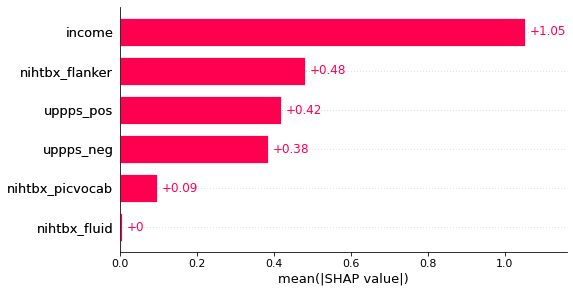

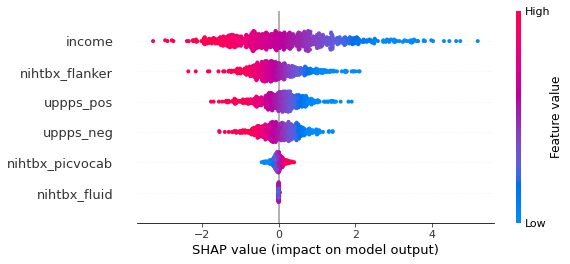

In [26]:

# YOU CODE HERE

# Create the explainer
explainer = shap.LinearExplainer(logl1, tr_x)
shap_values = explainer(tr_x)

# Plot
shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)


In [27]:

# Create an instance of our dataset
dataset = fx.Create_GAD()

# Add the context variables
dataset.add_context()

# Store performance
tr_acc, te_acc = [], []

# Split X,y
y = dataset.df['g_anxd']
X = dataset.df.drop(['g_anxd', 'x'], axis = 1)

# Create splits
kf = KFold(n_splits=5)

# Train/eval for each fold
for tr_idx, te_idx in kf.split(y):
    
    # Split train/test
    tr_x, te_x =  X.iloc[tr_idx, :], X.iloc[te_idx, :]
    tr_y, te_y =  y.iloc[tr_idx], y.iloc[te_idx]

    # Fit our model
    logl1 = LogisticRegression(penalty='l1', solver='liblinear')
    logl1.fit(tr_x, tr_y)

    # Get our predictions
    tr_pred = logl1.predict(tr_x)
    te_pred = logl1.predict(te_x)

    # Get accuracy
    tr_acc.append(accuracy_score(tr_y, tr_pred))
    te_acc.append(accuracy_score(te_y, te_pred))

print(f'Train Acc: {np.mean(np.array(tr_acc)):.3f} Test Acc: {np.mean(np.array(te_acc)):.3f}')


Train Acc: 0.990 Test Acc: 0.986


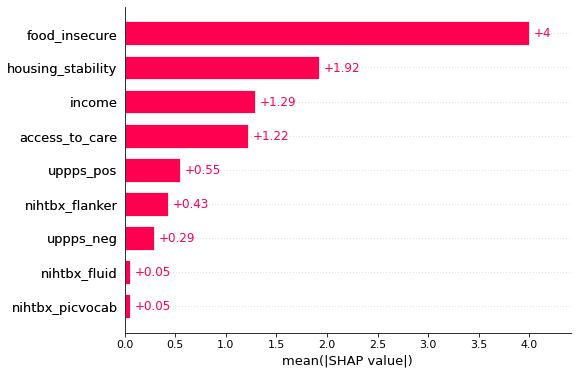

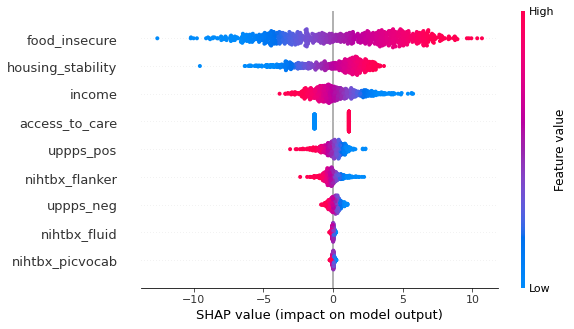

In [28]:

# YOU CODE HERE

# Create the explainer
explainer = shap.LinearExplainer(logl1, tr_x)
shap_values = explainer(tr_x)

# Plot
shap.plots.bar(shap_values.abs.mean(0))
shap.plots.beeswarm(shap_values)
